In [61]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from scipy.linalg import lu_factor, lu_solve

from hw1 import *

## Mathematical and Numerical Physics
### Numerical part 1
#### Kevin Vonk, s1706896, _Nov - Dec 2020_

## Problem 1
### a.
The Euler Forward scheme has been implemented in Python using the ways discussed in the lecture notes. We will run the simulation using $n_x \in \{8, 16, 32\}$. The generating code and resulting figures are found below. Here, we will also discuss the results.

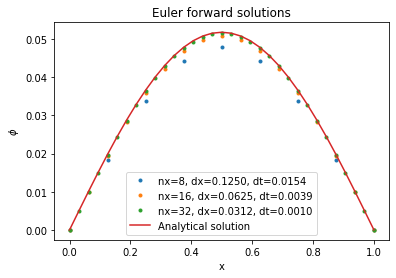

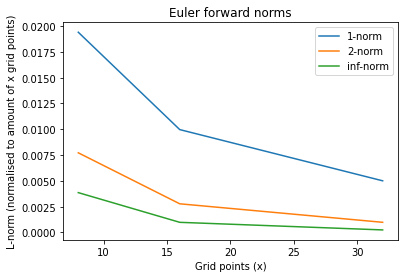

In [62]:
# Define some constants
ords = (1, 2, np.inf)
norms = [[] for ord in ords]

steps = (8, 16, 32)
x = (0, 1)
t = (0, 0.6)
M = 0.5
t_end = 0.6

# Compute the initial conditions and analytical solution
ic = lambda x, _: np.sin(np.pi * x)
ana = lambda x, t: np.exp(-M * np.pi**2 * t) * np.sin(np.pi * x)
err = lambda num, ana: num - ana

# Compute the solution for all given grid points in x
for nx in steps:
    nt = EulerForward1D.stable_time_steps(x, t, nx, M, nx_as_interval=True)
    ef = EulerForward1D(xbounds = x, tbounds = t, nx = nx, nt = nt, ic = ic, M = M, nx_as_interval=True)

    solution = ef.fullsolve()
    error = err(solution, ana(ef.x, t[1]))
    norms = [[*norm, np.mean(np.linalg.norm(error, ord=ord))] for norm, ord in zip(norms, ords)]
    
    plt.plot(ef.x, solution, '.', label=f"nx={nx}, dx={ef.dx:.4f}, dt={ef.dt:.4f}")

# Plot the results
plt.plot(ef.x, ana(ef.x, t[1]), label="Analytical solution")
plt.legend()
plt.xlabel("x")
plt.ylabel(r"$\phi$")
plt.title("Euler forward solutions")

plt.figure(2)
for norm, ord in zip(norms, ords):
    plt.plot(steps, norm, label=f"{ord}-norm")

plt.legend()
plt.xlabel("Grid points (x)")
plt.ylabel("L-norm (normalised to amount of x grid points)")
plt.title("Euler forward norms");

As we can observe from the numerical solutions, when we increase the amount of grid points we converge closer to the analytical solution. Note that increasing the amount of positional grid points also increases the amount of time grid points in order for the numerical stability to hold. The amount of grid points is computed automatically using the Von Neumann method, minimising the amount of required time grid points whilst still providing numerical stability.

The computed averaged / normalised norms show a similar picture, where the increase in grid points yield smaller errors.

### b.
Now, we implement the DuFort Frankel method. We need to ensure that $\frac{\Delta t}{\Delta x} \rightarrow 0$. This can be reinterpreted as $\Delta t \ll \Delta x$. A reasonable approximation to this is taking $\Delta t = 10^{-2} \Delta x$.

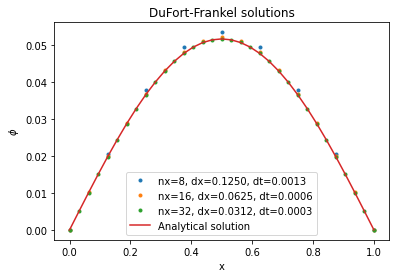

In [63]:
# Compute the solution for the various given grid steps
for nx in steps:
    nt = DuFortFrankel1D.stable_time_steps(x, t, nx, nx_as_interval=True)
    dff = DuFortFrankel1D(xbounds = x, tbounds = t, nx = nx, nt = nt, ic = ic, M = M, nx_as_interval=True)
    dff.fullsolve()

    plt.plot(dff.x, dff.solution, '.', label=f"nx={nx}, dx={dff.dx:.4f}, dt={dff.dt:.4f}")

# Plot the results
plt.plot(ef.x, ana(ef.x, t[1]), label="Analytical solution")
plt.legend()
plt.xlabel("x")
plt.ylabel(r"$\phi$")
plt.title("DuFort-Frankel solutions");

We can see from the resulting plot that the DuFort-Frankel method also nicely converges to the analytical solution. Of note here is that the DuFort-Frankel method seems to converge to the analytical solution using less positional grid points. However, the flip side of this is that our time step is about 6 times smaller, so the increased accuracy could just as well come from this decreased time step. One could argue that the factor $10^{2}$ difference between the time steps and the positional steps needn't be this big, but there is no clear cut limit given that needs to be upheld. In any case, this solution method seems stable using these paramters and provides a good convergence to the analytical solution.

### c.
In order to show that the Euler backwards method is stable, let us first consider the Euler backwards method itself,

\begin{equation}
    -\alpha \phi^{n+1}_{i+1} + (1 + 2\alpha) \phi^{n+1}_i - \alpha \phi^{n+1}_{i-1} = \phi^n_i.
    \label{eq:1c-eb}
\end{equation}

Applying the Von Neumann stability method to this equation means replacing $\phi^n_i$ with its Fourier mode,

\begin{equation}
    \psi^n_i = \lambda^n e^{jki\Delta x}, 
    \label{eq:1c-fourier}
\end{equation}

where $j$ indicates the complex number, and $i$ the positional index. Filling in eq. \eqref{eq:1c-fourier} into eq. \eqref{eq:1c-eb} yields,

\begin{equation}
    -\alpha \lambda^{n+1} e^{jk\Delta x}e^{jki\Delta x} + (1+2\alpha)\lambda^{n+1}e^{jki\Delta x} - \alpha \lambda^{n+1} e^{-jk\Delta x} e^{jki\Delta x} = \lambda^n e^{jki\Delta x}.
    \label{eq:1c-ebf-start}
\end{equation}

Dividing \eqref{eq:1c-ebf-start} by $\lambda^n e^{jki\Delta x}$,
\begin{align*}
    -\alpha \lambda (k) e^{jk\Delta x} + (1 - 2\alpha)\lambda (k) - \alpha \lambda (k)e^{-jk\Delta x} &= 1 \\
    \lambda (k) \left[-\alpha e^{jk\Delta x} -\alpha e^{-jk\Delta x} + 1 - 2\alpha\right] &= 1 \\
    \lambda(k)\left[-2\alpha\cos(k\Delta x) - 2\alpha + 1\right] &= 1 \\
    \frac{1}{1 - 2\alpha \left(\cos(k\Delta x) - 1\right)} &= \lambda(k).
\end{align*}

For the scheme to be stable, we have the constraint that $\lvert\lambda(k)\rvert \leq 1$. In this case, that means that $\lvert 1 - 2\alpha \left(\cos(k\Delta x) - 1\right) \rvert \geq 1$. Squaring this to get rid of the absolute value and solving,

\begin{align*}
    1 - 4\alpha\left[\cos(k\Delta x) - 1\right] + 4\alpha^2\left[\cos(k\Delta x)-1\right] &\geq 1 \\
    4\alpha\left[\cos(k\Delta x - 1\right]\left(\alpha\left[\cos(k\Delta x) - 1\right]-1\right) &\geq 0 \\
    4\alpha\left[\cos(k\Delta x) - 1\right] \geq 0 &\vee \alpha\left[\cos(k\Delta x) - 1\right] \geq 0 \\
    \rightarrow \alpha \geq 0 &\vee \alpha \geq \frac{1}{\cos(k\Delta x) - 1} \\
    &\rightarrow \alpha \geq 0 \; \text{(since $\cos(k\Delta x) \leq 1$)}.
\end{align*}

So, as long as $\alpha$ is positive, the solution will converge. Looking at $\alpha$,
\begin{equation*}
    \alpha = M\frac{\Delta t}{(\Delta x)^2},
\end{equation*}
we can see that $\Delta x$ can be any value, and that $\Delta t$ and $M$ need to be positive. Since these two will always be positive, we can conclude that the Euler backwards method is unconditionally stable.


### d.
The general form of the matrix $A$ can be written as such,

\begin{equation*}
    A = \begin{bmatrix}
        1 + 2\alpha & -\alpha & 0 & \cdots & 0 \\
        -\alpha & 1 + 2\alpha & -\alpha & \ddots & \vdots \\
        0 & -\alpha & 1 + 2\alpha & \ddots & \vdots \\
        \vdots & \ddots & \ddots & \ddots & \vdots
    \end{bmatrix}.
\end{equation*}

This matrix will be generated by the Euler Backwards solver, and we will compare the results of numpy's inversion, scipy's LU decomposition and our custom tridiagonal solver.

In [64]:
nx = 8
nt = 50

eb = EulerBackward1D(xbounds = x, tbounds = t, nx = nx, nt = nt, ic = ic, M = M, nx_as_interval=True)

matrix = eb.A

# Inversion
phi_inv = np.linalg.inv(matrix) @ eb.solution

# LU decomposition
phi_lu = lu_solve(lu_factor(matrix), eb.solution)

# Tridiagonal
phi_tri = next(eb.solve())

if np.allclose(phi_inv[1:-1], phi_lu[1:-1]) and np.allclose(phi_inv[1:-1], phi_tri[1:-1]):
    print("All solution methods (excl. boundaries) provide identical results")
elif np.allclose(phi_inv, phi_lu):
    print("Only library solutions provide identical results")
else:
    print("The solution methods are not equal")

All solution methods (excl. boundaries) provide identical results


As we can see, all three solution methods provide identical results. The reason we exclude the boundary conditions when checking for the solution equalities is because the solve function automatically forces the boundary conditions to be applied on the solution, whereas in the solutions provided by the libraries this is not yet done.

We will use the tridiagonal solver to solve the Euler Backwards method, since that is the one we implemented in the Euler Backwards solver already. As in the previous exercises, the convergence will be proven by showing that higher amounts of spatial grid points yield a result closer to the analytical solution. We will keep the time step constant in this case.

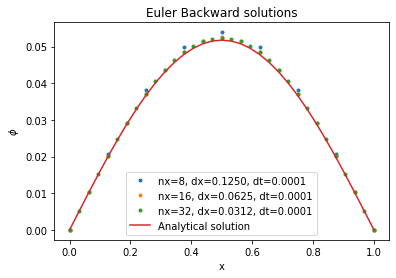

In [65]:
# Compute the solution for the various given grid steps
nt = 10000
for nx in steps:
    eb = EulerBackward1D(xbounds = x, tbounds = t, nx = nx, nt = nt, ic = ic, M = M, nx_as_interval=True)
    eb.fullsolve()

    plt.plot(eb.x, eb.solution, '.', label=f"nx={nx}, dx={eb.dx:.4f}, dt={eb.dt:.4f}")

# Plot the results
plt.plot(ef.x, ana(ef.x, t[1]), label="Analytical solution")
plt.legend()
plt.xlabel("x")
plt.ylabel(r"$\phi$")
plt.title("Euler Backward solutions");

What we can see from this result is that the solution seems to converge towards the analytical solution. However, compared to the Euler Forwards solution we are using a lot more time steps to achieve this. With a large number of grid points, say $n_x = 2048$ we converge to the analytical result better, but we still need a lot of time steps to achieve that. Conversely though, were the same to be done with the Euler Forward method, one would need quadratically more time steps for the same accuracy due to the increase in spatial grid points. So, the Euler Backward method does prove to be a useful method, just not for the small spatial grid sizes we are using here.

### d.
As before, we will now implement the Crank-Nicolson method and use the same methods to show convergence.

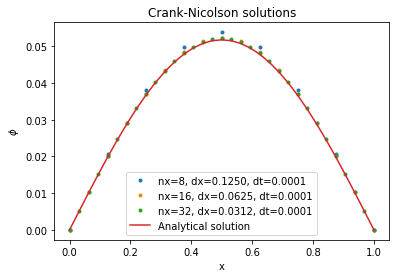

In [66]:
# Compute the solution for the various given grid steps
nt = 10000
for nx in steps:
    cn = CrankNicolson1D(xbounds = x, tbounds = t, nx = nx, nt = nt, ic = ic, M = M, nx_as_interval=True)
    cn.fullsolve()

    plt.plot(cn.x, cn.solution, '.', label=f"nx={nx}, dx={cn.dx:.4f}, dt={cn.dt:.4f}")

# Plot the results
plt.plot(cn.x, ana(cn.x, t[1]), label="Analytical solution")
plt.legend()
plt.xlabel("x")
plt.ylabel(r"$\phi$")
plt.title("Crank-Nicolson solutions");

From the figure above we can see that the Crank-Nicolson method also converges to the Analytical solution given sufficient time steps. At these spatial grid sizes it doesn't seem like there is a major benefit to using Crank-Nicolson over Euler Backward, since we need to use the same amount of time steps to achieve a result of similar accuracy while needing to perform an additional matrix multiplication $B\phi^n$. However, for larger spatial grids the reduction in the time error can lead to a more accurate result at the same amount of time steps or a quicker solution with the same accuracy.

## Problem 2
### a.

Starting from the inital expression,
\begin{equation*}
    \frac{\partial \phi}{\partial t} = M\nabla^2 \phi = M\left(\frac{\partial^2 \phi}{\partial x^2} + \frac{\partial^2 \phi}{\partial y^2}\right).
\end{equation*}

The Euler Forward method used first order forward in time and second order central difference in space. Let $i$ denote the index in $x$, and $j$ the index in $y$, then we can write using eq. (14) from the lecture notes in time and twice eq. (22) from the lecture notes in space,
\begin{align*}
    \frac{\phi^{n+1}_{i,j} - \phi^n_{i,j}}{\Delta t} &= M\left(\frac{\phi^n_{i+1,j} - 2\phi^n_{i,j} + \phi^n_{i-1,j}}{(\Delta x)^2} + \frac{\phi^n_{i,j+1} - 2\phi^n_{i,j} + \phi^n_{i,j-1}}{(\Delta y)^2}\right) \\
    \phi^{n+1}_{i,j} &= \frac{M\Delta t}{(\Delta x)^2(\Delta y)^2}\left[(\Delta y)^2\left(\phi^n_{i+1,j} -2\phi^n_{i,j} + \phi^n_{i-1,j}\right) + (\Delta x)^2\left(\phi^n_{i,j+1} - 2\phi^n_{i,j} + \phi^n_{i,j-1}\right)\right] + \phi^n_{i,j}.
\end{align*}

Unfortunately we cannot clean up this equation quite so nicely has we could have in the 1D cases. We could define two separate $\alpha_x$ and $\alpha_y$, or write the prefactor on the right hand side as some factor, but this (seemingly) doesn't yield any benefits. To ensure the stability of this method, we are given a $\Delta t$ from eq. (4) of the assignment. This expression could also be derived from the Von Neumann stability condition (it probably has been).

### b.
The results will be presented in a similar fashion as in the 1D cases. The code and figures can be found below.

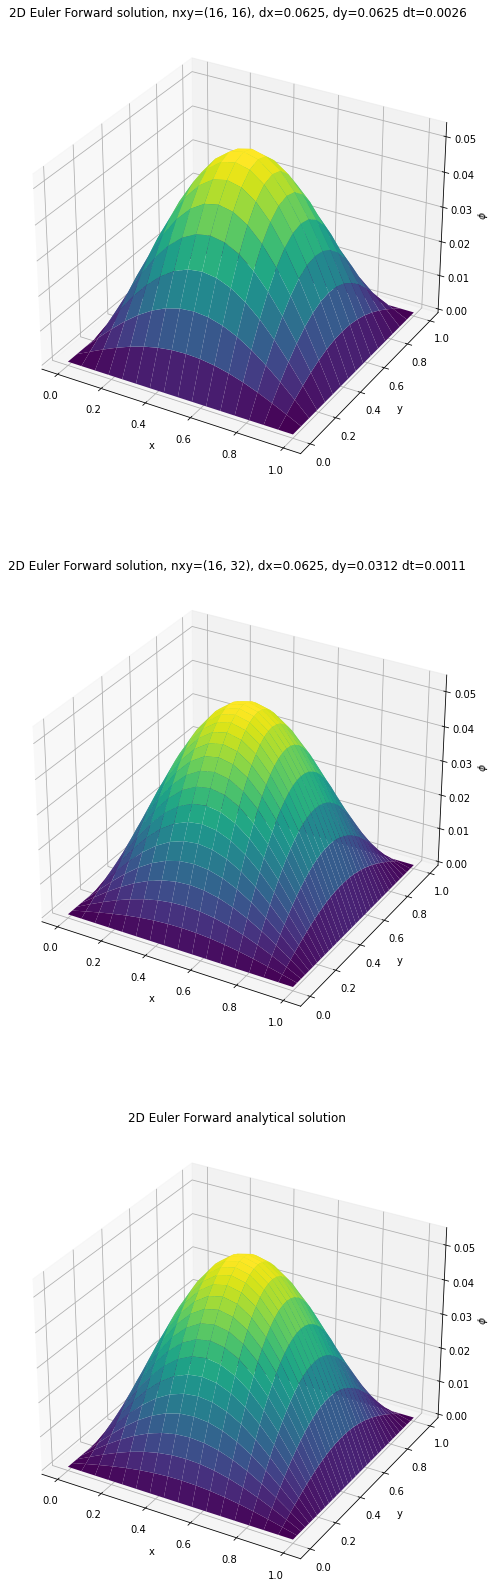

In [109]:
steps = ((16, 16), (16, 32))
xy = ((0, 1), (0, 1))
t = (0, 0.4)
M = 0.37

# Compute the initial conditions and analytical solution
ic = lambda x, y, _: np.sin(np.pi * x) * np.sin(np.pi * y)
ana = lambda x, y, t: np.exp(-2*M * np.pi**2 * t) * np.sin(np.pi * x) * np.sin(np.pi * y)

fig = plt.figure(figsize=(12.8, 3*9.6))

# Compute the solution for all given grid points in x
for i, nxy in enumerate(steps):
    nt = EulerForward2D.stable_time_steps(xy, t, nxy, M, nxy_as_interval=True)
    ef = EulerForward2D(xybounds = xy, tbounds = t, nxy = nxy, nt = nt, ic = ic, M = M, nxy_as_interval=True)

    solution = ef.fullsolve()
    
    # Setup plot
    ax = fig.add_subplot(len(steps)+1, 1, i+1, projection="3d")
    ax.plot_surface(ef.meshx, ef.meshy, solution, cmap="viridis")
    plt.title(f"2D Euler Forward solution, nxy={nxy}, dx={ef.dx:.4f}, dy={ef.dy:.4f} dt={ef.dt:.4f}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel(r"$\phi$")

# Plot the analytical solution
ax = fig.add_subplot(len(steps)+1, 1, len(steps)+1, projection="3d")
ax.plot_surface(ef.meshx, ef.meshy, ana(ef.meshx, ef.meshy, t[1]), cmap="viridis")
plt.title(f"2D analytical solution")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel(r"$\phi$");


As we can see from the above figures, the 2D Euler Forward solutions seem to follow the analytical result fairly reasonably. The peak of the smaller spatial grid is a bit lower compared to the analytical solution, similar to the behaviour we have seen for the 1D Euler Forward method. Given enough spatial and temporal grid points, we have a good convergence.